In [1]:
__author__ = 'Ragadeepika Pucha <rpucha@arizona.edu>, Stephanie Juneau <stephanie.juneau@noirlab.edu>' # single string; emails in <>
__version__ = '20221104' # yyyymmdd; version datestamp of this notebook
__datasets__ = ['sdss_dr12', 'sdss_dr16']  # datasets used in this notebook; for available datasets, see cell "Available datasets in Data Lab" further below
__keywords__ = ['sdss spectra', 'spectra stacking'], # keywords relevant to this notebook, e.g. ['science case','dwarf galaxies'] Use only keywords from the master list: https://github.com/astro-datalab/notebooks-latest/blob/master/internal/keywords.txt

# Stacking SDSS Spectra of Galaxies Selected from the BPT Diagram

*Ragadeepika Pucha (U.Arizona), Stéphanie Juneau (NOIRLab) & The Astro Data Lab Team*

### Table of contents
* [Goals & Summary](#goals)
* [Disclaimer & attribution](#attribution)
* [Imports & setup](#import)
* [Emission lines catalog from Portsmouth group](#ports)
* [SDSS spectra](#sdss)
    * [Functions to access and plot the spectra](#functions1)
    * [Plotting the spectra](#plot_spectra)
* [Ionization sources and the BPT diagram](#bpt)
* [Stacking spectra](#stack_spectra)
    * [Function to align and stack spectra](#functions2)
    * [Selecting galaxies from the BPT diagram](#select_bpt)
    * [Plotting stacked spectra](#plot_stack)
* [Resources and references](#resources)

<a class="anchor" id="goals"></a>
# Goals
In this notebook, we will show how to access and plot spectra of SDSS galaxies (or any SDSS object given its `specobjid`) using [SPARCL](https://astrosparcl.datalab.noirlab.edu/sparc/) (SPectral Analysis and Retrievable Catalog Lab). Further, we select emission-line galaxies based on their classification on a BPT diagram (named after "Baldwin, Phillips & Terlevich", the authors of the paper ([Baldwin et. al., 1981](https://ui.adsabs.harvard.edu/abs/1981PASP...93....5B/abstract)) who introduced this concept), and stack their spectra.

# Summary

Galaxy spectra provide us with vast information about the stellar, gas and dust properties of the galaxies. The SDSS spectra are hosted at Astro Data Lab and can be accessed from the Jupyter notebook interface directly. Below, we show how to access the spectrum of any given object. We also provide a functionality that can be used to overplot emission/absorption lines on the spectra. 

The different emission lines in the spectra provide information about ionization processes occuring in galaxies. These processes include star formation (SF), accretion onto an active galactic nucleus (AGN), and shocks. Using the traditional BPT diagram, galaxies can be divided into four different classes:
1. Star forming (SF)
2. Seyfert
3. LINER 
4. Composite

It can be useful to stack spectra of galaxies to study the emission lines and other spectral features more clearly. Stacking spectra helps increase the signal-to-noise ratio, which in turn helps detect faint spectral signatures and better study the average properties of the galaxies involved in the stacking. In this notebook, we stack the spectra of galaxies selected from each of the four BPT classes and compare their emission lines and overall spectral properties.

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: https://datalab.noirlab.edu/disclaimers.php

<a class="anchor" id="import"></a>
# Imports and setup

In [2]:
# std lib
from getpass import getpass
import random

# 3rd party 
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib
%matplotlib inline

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc
from sparcl.client import SparclClient

In [3]:
# Authentication
# Much of the functionality of spectrum services can be accessed without explicitly logging into Data Lab (the services then uses an anonymous login). 
# But some capabilities, for instance saving the results of your queries to your virtual storage space, require a login (i.e., you will need a registered user account).

# If you need to log in to Data Lab, uncomment the 'ac.login()' command and respond according to your prompts. 
# If you have previously logged into Data Lab, this cell will simply print your active user name.

#ac.login(input("Enter user name: (+ENTER) "), getpass("Enter password: (+ENTER) "))
ac.whoAmI()

'raga_steph'

In [4]:
## Setting up plots

# Font size
font = {'size':22}
matplotlib.rc('font', **font)

# Axes width
width = {'linewidth':3.0}
matplotlib.rc('axes', **width)

# x- and y- ticks
ticks = {'major.size':6.0, 'minor.size':4.0, 'major.width':3.0, 'minor.width':1.5, 'direction':'in',\
        'minor.visible':True}
matplotlib.rc('xtick', **ticks)
matplotlib.rc('ytick', **ticks)

# Include top and right ticks 
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

In [5]:
## SPARCL Client

client = SparclClient()

<a class="anchor" id="ports"></a>
# Emission lines catalog from Portsmouth group

The Portsmouth group created a Value Added Catalog (VAC) of stellar kinematics and emission line fluxes for the SDSS DR12 galaxies ([Thomas et al.2013](https://ui.adsabs.harvard.edu/abs/2013MNRAS.431.1383T/abstract)), based on the stellar population models of [Maraston & Stromback (2011)](https://ui.adsabs.harvard.edu/abs/2011MNRAS.418.2785M/abstract). They use an adaptation of the publicly available code - Gas AND Absorption Line Fitting (GANDALF; [Sarzi et al.2006](https://ui.adsabs.harvard.edu/abs/2006MNRAS.366.1151S/abstract)) - to fit stellar population and Gaussian emission line templates to the BOSS spectra. The code determines the kinematics of the gas (velocity and velocity dispersion), emission line fluxes and equivalent widths from the resulting emission line templates. 

More information about the Portsmouth stellar kinematics and emission line fluxes can be found [here](https://www.sdss.org/dr16/spectro/galaxy_portsmouth/#kinematics).

We can access this catalog (''emissionlinesport'') from the SDSS DR12 database (`sdss_dr12.emissionlinesport`).
The list and definitions of the columns are given both on the [Data Lab Table Browser](https://datalab.noirlab.edu/query.php?name=sdss_dr12.emissionlinesport)
and on the [SDSS Skyserver webpage](http://skyserver.sdss.org/dr16/en/help/browser/browser.aspx#&&history=description+emissionLinesPort+U).
For plotting the traditional BPT diagram, we need four emission lines - H$\alpha~\lambda$6562, H$\beta~\lambda$4861, [OIII]$\lambda$5006 and [NII]$\lambda$6583. In addition to these columns, we also consider the `bpt` column, which classifies galaxies into "Star Forming", "Seyfert", "LINER", "Seyfert/LINER", "Composite", based on the classification scheme from [Kauffmann et al. 2003](https://ui.adsabs.harvard.edu/abs/2003MNRAS.346.1055K/abstract), [Kewley et al. 2001](https://ui.adsabs.harvard.edu/abs/2001ApJ...556..121K/abstract) and [Schawinski et al. 2007](https://ui.adsabs.harvard.edu/abs/2007MNRAS.382.1415S/abstract). 

In [6]:
# List of emission lines we are interested in - 
emission_lines = ('Hb_4861', 'OIII_5006', 'Ha_6562', 'NII_6583')

# Creating a list of columns for all the emission lines for Flux, Flux_Err and Aon for each - 
selected_columns_sdss = ', \n'.join(['E.Flux_{0}, E.Flux_{0}_Err, E.Aon_{0}'.format(e) for e in emission_lines])

# Conditions - 
# Conditions on flux errors (flux errors > 0 and flux errors != Infinity)
err_cond_sdss = ' AND \n'.join(['(E.Flux_{0}_Err > 0) AND (E.Flux_{0}_Err != \'Infinity\')'.format(e) for e in emission_lines])
# Conditions on Signal to Noise ratio of all the emission lines
sn_cond_sdss = ' AND \n'.join(['(E.Flux_{0}/E.Flux_{0}_Err > 5)'.format(e) for e in emission_lines])

The `emissionlinesport` catalog contains several duplicates as a result of hosting all the information pertaining to all the spectra of all the sources. This includes some bad spectra as well as repeated spectra of the same object observed on multiple nights (different MJD). To select only the best spectra of unique objects, we JOIN this table with the SDSS DR16 `specobj` table, which contains only primary spectra objects (with `sciencePrimary > 0`).

In [7]:
# Write a query for the emission lines from the SDSS DR12 emissionlinesport catalog
# Applying the S/N cut of >= 5 for all the four emission lines
# Also applying the conditions that all the flux errors are >0 and != infinity.
# Applying condition on redshift - only selecting galaxies with 0.02 <= z <= 0.2
# We add bpt column - which marks the class of the galaxy based on its position on the BPT Diagram
# We use sdss_joinid to JOIN with SDSS DR16
# This is to get the SDSS DR16 specobjid of objects - which is used to access the spectra

query = """
SELECT 
E.ra as ra_sdss, E.dec as dec_sds, E.z, E.bpt,
E.mjd, E.plate, E.fiberid,
%s,
S.specobjid
FROM sdss_dr12.emissionlinesport as E
JOIN sdss_dr16.specobj as S
ON (E.sdss_joinid = S.sdss_joinid) AND (E.mjd = S.mjd)
WHERE (E.z > 0.02) AND (E.z < 0.2) AND
%s AND
%s
""" %(selected_columns_sdss, err_cond_sdss, sn_cond_sdss)

In [8]:
print(query)


SELECT 
E.ra as ra_sdss, E.dec as dec_sds, E.z, E.bpt,
E.mjd, E.plate, E.fiberid,
E.Flux_Hb_4861, E.Flux_Hb_4861_Err, E.Aon_Hb_4861, 
E.Flux_OIII_5006, E.Flux_OIII_5006_Err, E.Aon_OIII_5006, 
E.Flux_Ha_6562, E.Flux_Ha_6562_Err, E.Aon_Ha_6562, 
E.Flux_NII_6583, E.Flux_NII_6583_Err, E.Aon_NII_6583,
S.specobjid
FROM sdss_dr12.emissionlinesport as E
JOIN sdss_dr16.specobj as S
ON (E.sdss_joinid = S.sdss_joinid) AND (E.mjd = S.mjd)
WHERE (E.z > 0.02) AND (E.z < 0.2) AND
(E.Flux_Hb_4861_Err > 0) AND (E.Flux_Hb_4861_Err != 'Infinity') AND 
(E.Flux_OIII_5006_Err > 0) AND (E.Flux_OIII_5006_Err != 'Infinity') AND 
(E.Flux_Ha_6562_Err > 0) AND (E.Flux_Ha_6562_Err != 'Infinity') AND 
(E.Flux_NII_6583_Err > 0) AND (E.Flux_NII_6583_Err != 'Infinity') AND
(E.Flux_Hb_4861/E.Flux_Hb_4861_Err > 5) AND 
(E.Flux_OIII_5006/E.Flux_OIII_5006_Err > 5) AND 
(E.Flux_Ha_6562/E.Flux_Ha_6562_Err > 5) AND 
(E.Flux_NII_6583/E.Flux_NII_6583_Err > 5)



In [9]:
%%time
# It takes about 10 seconds
final_table = qc.query(sql=query, fmt = 'table')

CPU times: user 1.19 s, sys: 312 ms, total: 1.5 s
Wall time: 14.5 s


<a class="anchor" id="sdss"></a>
# SDSS spectra

In this section, we will show how to access and plot SDSS spectra using [SPARCL](https://astrosparcl.datalab.noirlab.edu/sparc/), a spectral access service provided by Astro Data Lab. In order to access the spectrum of an object, we will need the value of the `specobjid` of the object. It encodes information about the three identifiers - plate, MJD, and fiberID, along with run2d, which holds information about the reduction pipeline used. Each spectrum has a unique plate-MJD-fiberID value (though some objects observed on different nights/plates might have more than one spectrum). Information about identifying SDSS spectra can be found [here](https://www.sdss.org/dr16/spectro/spectro_basics/#IdentifyingSDSSspectra).

Information about the SDSS spectroscopic data reduction and spectra formats is given [here](https://www.sdss.org/dr16/spectro/pipeline/#SpectroscopicDataReduction).

<a class="anchor" id="functions1"></a>
## Functions to access and plot SDSS spectra

In [10]:
# Function 1 -

def get_sdss_spectra(specobjid, rest_frame = True):
    """
    Function to access the SDSS spectra of any object using SPARCL.
    
    Returns the arrays of wavelength, flux, model and ivar.
    Returns the rest-frame arrays if rest_frame = True.
    If rest_frame = False, returns the observed-frame arrays.
    
    Parameters
    ----------
    specobjid : int
        Unique SDSS spectrum id
        
    rest_frame : bool
        Whether or not to return the rest-frame values. Default is True.
    
    Returns
    -------
    wavelength : array
        Wavelength array (Rest-frame values if rest_frame = True)
        
    flux : array
        Flux values array (Rest-frame values if rest_frame = True)
    
    model : array
        Model values array (Rest-frame values if rest_frame = True)
        
    ivar : array
        Inverse variance array (Rest-frame values if rest_frame = True)

    """
    
    ## Retrieve the spectra
    res = client.retrieve_by_specid(specid_list = [specobjid], 
                                    include = ['id', 'redshift', 'flux', 'wavelength', 'model', 'ivar'],
                                    dataset_list = ['SDSS-DR16', 'BOSS-DR16'])
    ## Record of the spectra
    res_record = res.records[0]
    
    wavelength = res_record.wavelength
    flux = res_record.flux
    model = res_record.model
    ivar = res_record.ivar
    z = res_record.redshift
    
    if (rest_frame == True):
        # If rest_frame = True, we convert the different arrays into their rest-frame values
        wavelength = wavelength/(1+z)
        flux = flux*(1+z)
        model = model*(1+z)
        ivar = ivar/((1+z)**2)
    
    return (wavelength, flux, model, ivar)

In [11]:
# Function 2 - 

def add_lines(z, ax = None, rest_frame = True, em_label = True, abs_label = True, em_lines = None, abs_lines = None):
    """
    Function to add emission and/or absorption lines onto a plot. 
    
    If em_lines or abs_lines is given, plotting only the specified lines.
    If no lines are given, plotting all the lines that are present in x-range of the plot.
    
    Parameters
    ----------
    z : float
        Redshift value of the source
    
    ax : AxesSubplot
        The axis onto which the emission/absoption lines needs to be plotted.
        If ax = None, then the plotting function uses plt, rather than axis.
        
    rest_frame : bool
        Whether or not the plot is in rest-frame. Default is True.
    
    em_label : bool
        Whether or not to label the emission lines. Default is True.
        
    abs_label : bool
        Whether or not to label the absorption lines. Default is True.
    
    em_lines : list
        List of emission lines to label
    
    abs_lines : list
        List of absorption lines to label
    
    Returns
    -------
    None
    
    """
    
    # List of lines
    # This is the set of emission lines from the spZline files. 
    # All the wavelengths are in vaccuum wavelengths.

    # Emission Lines
    emission_lines = [
    {"name" : "Ly-alpha",       "lambda" : 1215.67,  "emission": True,  "label" : "Ly$\\alpha$"},
    {"name" : "N V 1240",       "lambda" : 1240.81,  "emission": True,  "label" : "N V"},
    {"name" : "C IV 1549",      "lambda" : 1549.48,  "emission": True,  "label" : "C IV" },
    {"name" : "He II 1640",     "lambda" : 1640.42,  "emission": True,  "label" : "He II"},
    {"name" : "C III] 1908",    "lambda" : 1908.734, "emission": True,  "label" : "C III]"},
    {"name" : "Mg II 2799",     "lambda" : 2800.315, "emission": True,  "label" : "Mg II" },
    {"name" : "[O II] 3725",    "lambda" : 3727.092, "emission": True,  "label" : " "},
    {"name" : "[O II] 3727",    "lambda" : 3729.875, "emission": True,  "label" : "[O II]"}, 
    {"name" : "[Ne III] 3868",  "lambda" : 3869.857, "emission": True,  "label" : "[Ne III]"},
    {"name" : "H-zeta",         "lambda" : 3890.151, "emission": True,  "label" : "H$\\zeta$"},
    {"name" : "[Ne III] 3970",  "lambda" : 3971.123, "emission": True,  "label" : "[Ne III]"},
    {"name" : "H-epsilon",      "lambda" : 3971.195, "emission": True,  "label" : "H$\\epsilon$"}, 
    {"name" : "H-delta",        "lambda" : 4102.892, "emission": True,  "label" : "H$\\delta$"},
    {"name" : "H-gamma",        "lambda" : 4341.684, "emission": True,  "label" : "H$\\gamma$"},
    {"name" : "[O III] 4363",   "lambda" : 4364.435, "emission": True,  "label" : "[O III]"},
    {"name" : "He II 4685",     "lambda" : 4686.991, "emission": True,  "label" : "He II"},
    {"name" : "H-beta",         "lambda" : 4862.683, "emission": True,  "label" : "H$\\beta$"},
    {"name" : "[O III] 4959",   "lambda" : 4960.294, "emission": True,  "label" : "[O III]" },
    {"name" : "[O III] 5007",   "lambda" : 5008.239, "emission": True,  "label" : "[O III]" },
    {"name" : "He II 5411",     "lambda" : 5413.025, "emission": True,  "label" : "He II"},
    {"name" : "[O I] 5577",     "lambda" : 5578.888, "emission": True,  "label" : "[O I]" },
    {"name" : "[N II] 5755",    "lambda" : 5756.186, "emission": True,  "label" : "[Ne II]" },
    {"name" : "He I 5876",      "lambda" : 5877.308, "emission": True,  "label" : "He I" },
    {"name" : "[O I] 6300",     "lambda" : 6302.046, "emission": True,  "label" : "[O I]" },
    {"name" : "[S III] 6312",   "lambda" : 6313.806, "emission": True,  "label" : "[S III]" },
    {"name" : "[O I] 6363",     "lambda" : 6365.535, "emission": True,  "label" : "[O I]" },
    {"name" : "[N II] 6548",    "lambda" : 6549.859, "emission": True,  "label" : "[N II]" },
    {"name" : "H-alpha",        "lambda" : 6564.614, "emission": True,  "label" : "H$\\alpha$" },
    {"name" : "[N II] 6583",    "lambda" : 6585.268, "emission": True,  "label" : "[N II]" },
    {"name" : "[S II] 6716",    "lambda" : 6718.294, "emission": True,  "label" : "[S II]" },
    {"name" : "[S II] 6730",    "lambda" : 6732.678, "emission": True,  "label" : "[S II]" },
    {"name" : "[Ar III] 7135",  "lambda" : 7137.758, "emission": True,  "label" : "[Ar III]" },]


    # Absorption lines
    absorption_lines = [
    {"name" : "H12",            "lambda" : 3751.22,  "emission": False, "label" : "H12"},
    {"name" : "H11",            "lambda" : 3771.70,  "emission": False, "label" : "H11"},
    {"name" : "H10",            "lambda" : 3798.98,  "emission": False, "label" : "H10"},
    {"name" : "H9",             "lambda" : 3836.48,  "emission": False, "label" : "H9"},
    {"name" : "H-zeta",         "lambda" : 3890.151, "emission": False, "label" : "H$\\zeta$" },
    {"name" : "K (Ca II 3933)", "lambda" : 3934.814, "emission": False, "label" : "K (Ca II)"},
    {"name" : "H (Ca II 3968)", "lambda" : 3969.623, "emission": False, "label" : "H (Ca II)"},
    {"name" : "H-epsilon",      "lambda" : 3971.195, "emission": False, "label" : "H$\\epsilon$"}, 
    {"name" : "H-delta",        "lambda" : 4102.892, "emission": False, "label" : "H$\\delta$" },
    {"name" : "G (Ca I 4307)",  "lambda" : 4308.952, "emission": False, "label" : "G (Ca I)"},
    {"name" : "H-gamma",        "lambda" : 4341.684, "emission": False, "label" : "H$\\gamma$"},
    {"name" : "H-beta",         "lambda" : 4862.683, "emission": False, "label" : "H$\\beta$"},
#    {"name" : "Mg I 5175",      "lambda" : 5176.441, "emission": False, "label" : "Mg I"},  #Triplet
    {"name" : "Mg I 5183",      "lambda" : 5185.048, "emission": False, "label" : " "},
    {"name" : "Mg I 5172",      "lambda" : 5174.125, "emission": False, "label" : " "},
    {"name" : "Mg I 5167",      "lambda" : 5168.762, "emission": False, "label" : "Mg I"},
    {"name" : "D2 (Na I 5889)", "lambda" : 5891.582, "emission": False, "label" : " " },
    {"name" : "D1 (Na I 5895)", "lambda" : 5897.554, "emission": False, "label" : "D1,2 (Na I)" },
    {"name" : "H-alpha",        "lambda" : 6564.614, "emission": False, "label" : "H$\\alpha$"},
    ]
    
    if (ax == None):
        # If there is no axes given, plotting with the plt function
        ax = plt.gca()
    
    if (em_lines != None):
        # Choosing the emission lines listed by the user
        emission_lines = list(filter(lambda x: x['name'] in em_lines, emission_lines))
    
    if (abs_lines != None):
        # Choosing the absorption lines listed by the user
        absorption_lines = list(filter(lambda x: x['name'] in abs_lines, absorption_lines)) 
    
    xbounds = ax.get_xbound()   # Getting the x-range of the plot 
    # This is for selecting only those lines that are visible in the x-range of the plot
    
    for ii in range(len(emission_lines)):
        # If rest_frame = False, redshifting the emission lines to the observed frame of the source
        if (rest_frame == False):
            lam = emission_lines[ii]['lambda']*(1+z)
        else:
            lam = emission_lines[ii]['lambda']
        # Plotting the emission lines if they are within the x-range of the plot
        if (emission_lines[ii]['emission']) & (lam > xbounds[0]) & (lam < xbounds[1]):
            ax.axvline(lam, 0.95, 1.0, color = 'b', lw = 1.0)
            ax.axvline(lam, color = 'b', lw = 1.0, linestyle = ':')
            trans = ax.get_xaxis_transform()
            if (em_label == True):
                # Labeling the emission lines if em_label = True
                ax.annotate(emission_lines[ii]['label'], xy = (lam, 1.05), xycoords = trans, \
                         fontsize = 12, rotation = 90, color = 'b')
            
    for ii in range(len(absorption_lines)):
        # If rest_frame = False, redshifting the absorption lines to the observed frame of the source
        if (rest_frame == False):
            lam = absorption_lines[ii]['lambda']*(1+z)
        else:
            lam = absorption_lines[ii]['lambda']
        # Plotting the absorption lines if they are within the x-range of the plot
        if (lam > xbounds[0]) & (lam < xbounds[1]):
            ax.axvline(lam, 0.2, 1.0, color = 'r', lw = 1.0, linestyle = ':')
            trans = ax.get_xaxis_transform()
            if (abs_label == True):
                # Labeling the absorption lines if abs_label = True
                ax.annotate(absorption_lines[ii]['label'], xy = (lam, 0.05), xycoords = trans, \
                         fontsize = 12, rotation = 90, color = 'r')

In [12]:
# Function - 3
# This function utilises both the above functions

def plot_sdss_spectra(wavelength, flux, model, ivar, z, rest_frame = True, \
                      xlim = None, ylim = None, \
                      spectra_kwargs = {'color': 'grey', 'alpha': 0.5}, model_kwargs = {'color': 'k', 'linewidth': 2.0},\
                      emission_lines = False, absorption_lines = False, \
                      em_lines = None, abs_lines = None):
    
    """
    Function to plot the SDSS spectra.
    
    Parameters
    ----------
    wavelength : array
        Wavelength array 
        
    flux : array
        Flux values array 
    
    model : array
        Model values array 
        
    ivar : array
        Inverse variance array 
        
    z : float
        Redshift of the source
        
    rest_frame : bool
        Whether the input spectra is in rest_frame or not. Default is True.
    
    xlim : list or tuple
        Setting the xrange of the plot
        
    ylim : list or tupe
        Setting the yrange of the plot
    
    emission_lines - bool
        Whether or not to overplot emission lines. Default is False.
    
    absorption_lines - bool
        Whether or not to overplot absorpion lines. Default is False.
        
    em_lines - list
        List of emission lines to plot
        If not mentioned, all the lines in the default list will be plotted.
        
    abs_lines - list
        List of absorption lines to plot
        If not mentioned, all the lines in the default list will be plotted.
    
    spectra_kwargs - dict
        Plotting keyword arguments for the spectra
        
    model_kwargs - dict
        Plotting keyword arguments for the model
        
    Returns
    -------
    None
    
    """
    # Setting up the plot
    plt.figure(figsize = (14,6))
    plt.plot(wavelength, flux*(ivar > 0), **spectra_kwargs)
    plt.plot(wavelength, model*(ivar > 0), **model_kwargs)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('$F_{\lambda}$ ($10^{-17}~ergs~s^{-1}~cm^{-2}~\AA^{-1}$)')
    
    # Plotting Absorption/Emission lines - only works if either of the lines is set to True
    if (emission_lines == True)|(absorption_lines == True):    
        if (emission_lines == False):
            # Sending empty array of em_lines if emission_lines = False
            em_lines = []
        if (absorption_lines == False):
            # Sending empty array of abs_lines 
            abs_lines = []
            
        # Plotting function to add emission/absorption lines
        add_lines(ax = None, z = z, rest_frame = rest_frame, \
                           em_label = True, abs_label = True, em_lines = em_lines, abs_lines = abs_lines)

<a class="anchor" id="plot_spectra"></a>
## Plotting the spectra

Function to plot the spectra for any object - 

        plot_sdss_spectra(wavelength, flux, model, ivar, z, [release], [rest_frame], \
                      [xlim], [ylim], [spectra_kwargs], [model_kwargs],\
                      [emission_lines], [absorption_lines], [em_lines], [abs_lines])
where

        wavelength               Wavelength array of the spectrum of the object 
        flux                     Flux array of the spectrum of the object
        model                    Model array of the spectrum of the object
        ivar                     Inverse variance of the spectrum of the object
        z                        Redshift of the object
        rest_frame               [optional, default = True] whether the input spectra is in rest-frame or not
        xlim                     [optional, default = None] wavelength range to be plotted for the spectra
        ylim                     [optional, default = None] yrange to be plotted for the spectra
        spectra_kwargs           [optional, default = {'color': 'grey', 'alpha': 0.5}]
                                 Plotting kwargs for the spectra
        model_kwargs             [optional, default = {'color': 'k', 'linewidth': 2.0}]
                                 Plotting kwargs for the model
        emission_lines           [optional, default = False] Whether or not to overplot the emission lines
        absorption_lines         [optional, default = False] Whether or not to overplot the absorption lines
        em_lines                 [optional, default = None] List of emission lines to be overplotted
                                 If emission_lines = True, and em_lines = None - all the lines present within
                                 the xrange of the plot are overplotted.
        abs_lines                [optional, default = None] List of absorption lines to be overplotted
                                 If aborption_lines = True, and abs_lines = None - all the lines present within
                                 the xrange of the plot are overplotted.

In [13]:
# Assigning variables for the columns required to plot the spectra -

z = final_table['z'].data

## We need to convert the numpy array of specobjid into a int list to work with SPARCL
specobjid = [int(s) for s in final_table['specobjid'].data]

In [14]:
# Print number of objects in table

N_table = len(final_table)
print(N_table)

156748


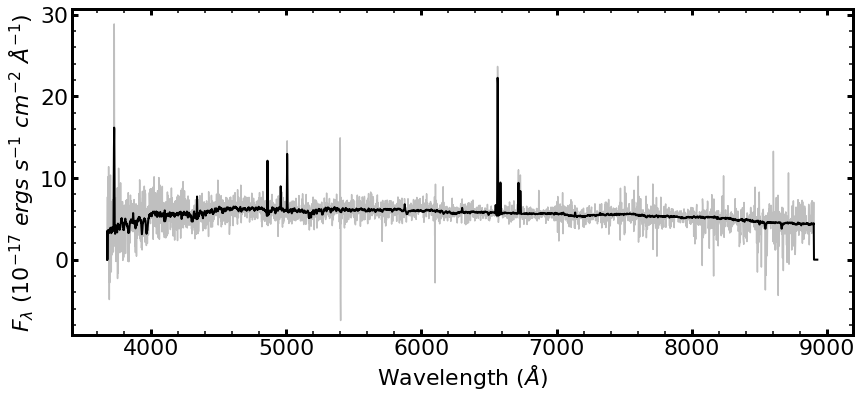

In [15]:
# We will first plot with all the default values - 
# Requires specobjid and z

index = 10     # Change the value between 0 and N_table-1 to plot different spectra in rest-frame 

# Getting the wavelength, flux, model and ivar arrays for the given source
wavelength, flux, model, ivar = get_sdss_spectra(specobjid[index], rest_frame = True)
plot_sdss_spectra(wavelength, flux, model, ivar, z[index])

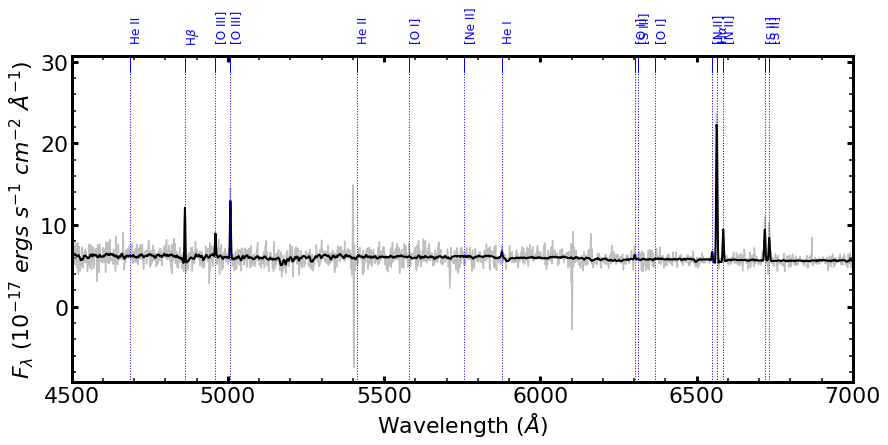

In [16]:
# Changing the default values for the plotting function

index = 10           # Change the value between 0 and N_table-1 to plot different spectra in rest-frame 

plot_sdss_spectra(wavelength, flux, model, ivar, z[index], rest_frame = True, \
                      xlim = [4500, 7000], ylim = None, \
                      spectra_kwargs = {'color': 'grey', 'alpha': 0.5}, \
                      model_kwargs = {'color': 'k', 'linewidth': 2.0},\
                      emission_lines = True, absorption_lines = True, \
                      em_lines = None,  abs_lines = [])

# The actual spectra from the SDSS is shown in grey and the model is shown in black.
# You can change it to any color that you want by using the spectra_kwargs and model_kwargs keywords.

<a class="anchor" id="bpt"></a>
# Ionization sources and the BPT diagram

Emission lines in the spectra of galaxies can be a result of several sources of ionization, such as star formation, AGN, and shocks. The BPT diagram is constructed from the optical line ratios [OIII]/H$\beta$ and [NII]/H$\alpha$. The position of any galaxy in this space depends on the metallicity of the ionized gas, the hardness of the ionizing radiation and the ionization parameter. We consider four classes of excitation sources here, which are located at different positions of the BPT diagram based on their domination source of ionization -

* Star-Forming Galaxies (SF)
* Seyferts (Moderate-to-High luminosity AGN)
* LINERs (Low-Ionization Nuclear Emission Regions; shocks and/or low-luminosity AGN)
* Composite Galaxies (Mixture of SF, shocks and/or AGN activity)

For more information, see a recent review on understanding galaxy evolution from their emission lines by [Kewley et al. 2019](https://ui.adsabs.harvard.edu/abs/2019ARA%26A..57..511K/abstract).

In [17]:
# Computing the logarithm of line ratios for the BPT Diagram - 

Nii_Ha = np.log10(final_table['flux_nii_6583']/final_table['flux_ha_6562'])
Oiii_Hb = np.log10(final_table['flux_oiii_5006']/final_table['flux_hb_4861'])

In [18]:
# Assigning a variable for the bpt column
bpt = final_table['bpt']   # BPT Classification

# Creating labels for the different classes based on BPT Column - 

is_sf = (bpt == 'Star Forming')
is_sy = (bpt == 'Seyfert')
is_comp = (bpt == 'Composite')
is_liner = (bpt == 'LINER')

In [19]:
# 2-d histogram density of all the galaxies

dens_all,_,_ = np.histogram2d(Nii_Ha, Oiii_Hb, range = [[-2.0, 0.75], [-1.2, 1.2]], bins = 100, normed = True)
dens_all = dens_all.T

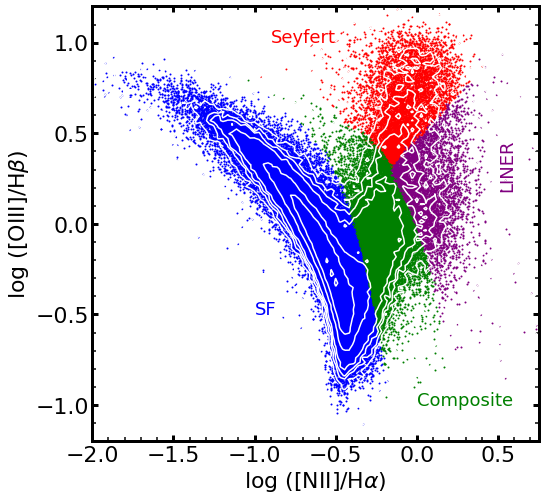

In [20]:
# BPT Diagram color-coded based on the class

plt.figure(figsize = (8,8))

plt.scatter(Nii_Ha[is_sy], Oiii_Hb[is_sy], color = 'r', s = 1.0)             # Seyferts in red (r)
plt.scatter(Nii_Ha[is_sf], Oiii_Hb[is_sf], color = 'b', s = 1.0)             # SF in blue (b)
plt.scatter(Nii_Ha[is_comp], Oiii_Hb[is_comp], color = 'g', s = 1.0)         # Composites in green (g)
plt.scatter(Nii_Ha[is_liner], Oiii_Hb[is_liner], color = 'purple', s = 1.0)  # LINERs in purple
plt.contour(dens_all, colors = 'white', extent = (-2.0, 0.75, -1.2, 1.2), levels = [0.0, 0.1, 0.2, 0.3, 0.5, 1.5, 3.0, 6.0])
plt.xlim([-2, 0.75])
plt.ylim([-1.2, 1.2])
plt.text(-1.0, -0.5, 'SF', color = 'blue', fontsize = 18)
plt.text(0.0, -1.0, 'Composite', color = 'green', fontsize = 18)
plt.text(0.5, 0.2, 'LINER', color = 'purple', fontsize = 18, rotation = 90)
plt.text(-0.9, 1.0, 'Seyfert', color = 'r', fontsize = 18)
plt.xlabel('log ([NII]/H$\\alpha$)')
plt.ylabel('log ([OIII]/H$\\beta$)')

plt.show()

From this diagram, we can see that the Seyferts and LINERs have higher [NII]/H$\alpha$ and [OIII]/H$\beta$ compared to SF galaxies. In a nebula photoionized by young, massive stars, the low-ionization transition [NII] is weak. A hard AGN radiation field boosts the production of collisionally excited forbidden line emission. LINERs have lower luminosities than Seyferts, requiring harder ionizing radiation field than SF galaxies, but a lower ionization parameter than Seyferts. They can be produced by low-luminosity AGN, cooling flows, starburst driven winds, or shock-heated gas. AGN tend to reside in most massive and most metal-rich galaxies. Thus, an AGN contribution raises the [NII]/H$\alpha$ ratio above the SF galaxies. Composites may contain a mixture of SF, shock excitation and/or AGN activity.

<a class="anchor" id="stack_spectra"></a>
# Stacking spectra

Spectra stacking in an important technique to study the general properties of galaxies. This process increases the signal-to-noise ratio and thus highlights the continuum and the emission lines more clearly, and may further reveal weak lines that are rarely detected in individual spectra. In order to look at the typical properties of galaxies from the four classes - SF, AGN, LINER and Composites, we will select random galaxies from each of these classes and stack their spectra.

In this section, we show how to align and stack spectra of a number of galaxies.

<a class="anchor" id="functions2"></a>
## Function to align and stack spectra

This function takes in a table of SDSS objects and outputs the stacked spectrum array values. Here, it will call the first function `get_sdss_spectra`.

In [45]:
## Function 4 -

def stack_spectra(table):
    """
    Function to Stack the spectra of all the sources in the given table.
    Uses SPARCL to retrieve spectra
    
    Returns an inverse variance weighted mean of the input spectra.
    
    Parameters
    ----------
    table : table
        Table of sources whose spectra need to be stacked
    
    Returns
    -------
    wavelength_stack : array
        Wavelength array of the stacked spectra
        
    flux_stack : array
        Flux array of the stacked spectra
    
    model_stack : array
        Model array of the stacked spectra
    
    """
    
    # Create an array with the targeted loglam values - reference array
    loglam_ref = np.arange(3.5000, 3.9000, 0.0001).astype('float32')
    
    # Create empty lists for flux, ivar and model - 
    flux_array = []
    model_array = []
    ivar_array = []
    
    # Extract the necessary columns from the table
    # redshift = table['z']
    specobjid = [int(s) for s in table['specobjid'].data]
    
    # Number of spectra - 
    n = len(table)
    
    ## Retrieve the spectra
    res = client.retrieve_by_specid(specid_list = specobjid, 
                                    include = ['id', 'redshift', 'flux', 'wavelength', 'model', 'ivar'],
                                    dataset_list = ['SDSS-DR16', 'BOSS-DR16'], limit = None)
    
    ## All the spectra have the same spacing in log wavelength.
    ## We shift the spectra in the observed wavelength range to fill the same log wavelength range
    ## Join the different arrays of the individual spectra into a single array
    
    for ii in range(n):        
        ## Get rest-frame spectra of each object
        res_rec = res.records[ii]
        z = res_rec.redshift
        lam = res_rec.wavelength/(1+z)
        flux = res_rec.flux*(1+z)
        model = res_rec.model*(1+z)
        ivar = res_rec.ivar/((1+z)**2)
        
        loglam = np.around(np.log10(lam), 4).astype('float32')
        # The log of reference wavelength and log of wavelength range of each spectra are converted to 'float32'
        # This helps in avoiding the rounding errors
        
        # Creating empty arrays for flux, inverse variance and model 
        # with the same length as the reference loglam array
        fl = np.zeros(len(loglam_ref))
        iv = np.zeros(len(loglam_ref))
        ml = np.zeros(len(loglam_ref))
        
        # Truth_array - A boolen array which will define what pixels the spectra have been shifted to
        truth_array = np.zeros(len(loglam_ref), dtype = bool)
        
        # Find common elements between the reference and spectra wavelengths - 
        ll_common = np.intersect1d(loglam_ref, loglam)
        
        # Finding the indices of the first pixel in the common array in both reference and spectrum arrays
        ref_start = np.where(loglam_ref == ll_common[0])[0][0]
        spec_start = np.where(loglam == ll_common[0])[0][0]
        
        m = min(len(loglam_ref[ref_start:]), len(loglam[spec_start:]))
        
        # Match the first pixel of the common loglam values with the reference array 
        # Mark the number of pixels with the spectra starting from the first pixel to be True
        truth_array[ref_start:ref_start+m] = True

        # Fill the flux, inverse variance and model arrays
        fl[truth_array] = flux[spec_start:spec_start+m]
        iv[truth_array] = ivar[spec_start:spec_start+m]
        ml[truth_array] = model[spec_start:spec_start+m]
        
        # Where the reference array is empty, fill the flux and model with nan values
        # Set inverse variance to zero for these pixels
        fl[~truth_array] = np.nan
        iv[~truth_array] = 0.0
        ml[~truth_array] = np.nan
        
        # Create a masked array with 'nan' values marked
        # This avoids the pixels filled with 'nan' when stacking
        fl = np.ma.masked_array(fl, np.isnan(fl))
        iv = np.ma.masked_array(iv, np.isnan(iv))
        ml = np.ma.masked_array(ml, np.isnan(ml))
        
        flux_array.append(fl)
        model_array.append(ml)
        ivar_array.append(iv)
        
    # Stack the spectra by weighted average 
    wavelength_stack = 10**(loglam_ref)
    flux_stack = np.ma.average(flux_array, axis = 0, weights = ivar_array)
    model_stack = np.ma.average(model_array, axis = 0, weights = ivar_array)
    
    flux_stack = flux_stack.filled(np.nan)
    model_stack = model_stack.filled(np.nan)
    
    return (wavelength_stack, flux_stack, model_stack)

<a class="anchor" id="select_bpt"></a>
## Selecting galaxies from the BPT diagram

In order to compare the general spectral properties of galaxies from the four different classes, we randomly select 100 galaxies from each BPT class to stack their spectra. To be consistent, we select the galaxies from squares of same area from the four regions.

In [22]:
## Defining vertices the lower-left corners of the four squares

sy_x, sy_y = -0.15, 0.55
sf_x, sf_y = -0.65, -0.05
liner_x, liner_y = 0.0, 0.05
comp_x, comp_y = -0.25, 0.0

# Defining the width and height size
width = 0.1
height = 0.1

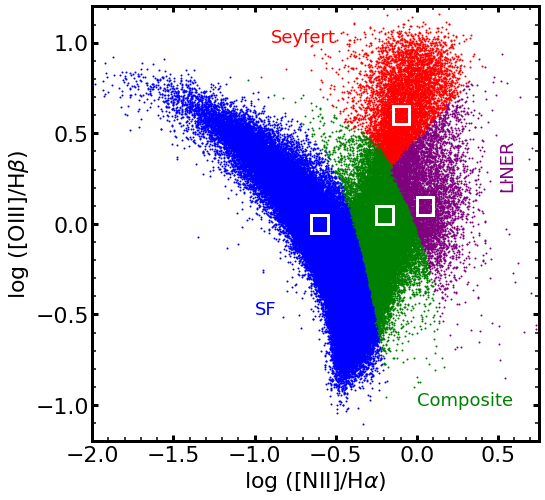

In [23]:
s1= Rectangle(xy = (sy_x, sy_y), width = width, height = height, color = 'white', lw = 3.0, fill = False)
s2 = Rectangle(xy = (sf_x, sf_y), width = width, height = height, color = 'white', lw = 3.0, fill = False)
s3 = Rectangle(xy = (liner_x, liner_y), width = width, height = height, color = 'white', lw = 3.0, fill = False)
s4 = Rectangle(xy = (comp_x, comp_y), width = width, height = height, color = 'white', lw = 3.0, fill = False)

plt.figure(figsize = (8,8))

plt.scatter(Nii_Ha[is_sy], Oiii_Hb[is_sy], color = 'r', s = 1.0)
plt.scatter(Nii_Ha[is_sf], Oiii_Hb[is_sf], color = 'b', s = 1.0)
plt.scatter(Nii_Ha[is_comp], Oiii_Hb[is_comp], color = 'g', s = 1.0)
plt.scatter(Nii_Ha[is_liner], Oiii_Hb[is_liner], color = 'purple', s = 1.0)
plt.gca().add_patch(s1)
plt.gca().add_patch(s2)
plt.gca().add_patch(s3)
plt.gca().add_patch(s4)
plt.text(-1.0, -0.5, 'SF', color = 'blue', fontsize = 18)
plt.text(0.0, -1.0, 'Composite', color = 'green', fontsize = 18)
plt.text(0.5, 0.2, 'LINER', color = 'purple', fontsize = 18, rotation = 90)
plt.text(-0.9, 1.0, 'Seyfert', color = 'r', fontsize = 18)
plt.xlim([-2, 0.75])
plt.ylim([-1.2, 1.2])
plt.xlabel('log ([NII]/H$\\alpha$)')
plt.ylabel('log ([OIII]/H$\\beta$)')

plt.show()

In this figure, the four white boxes show the regions from where we will perform the random selection of galaxies.

In [24]:
# Regions of the white boxes - 
# Getting the indices of the sources within the four boxes

sy_box = np.where((Nii_Ha >= sy_x) & (Nii_Ha <= sy_x+width) & (Oiii_Hb >= sy_y) & (Oiii_Hb <= sy_y+height))[0]
sf_box = np.where((Nii_Ha >= sf_x) & (Nii_Ha <= sf_x+width) & (Oiii_Hb >= sf_y) & (Oiii_Hb <= sf_y+height))[0]
liner_box = np.where((Nii_Ha >= liner_x) & (Nii_Ha <= liner_x+width) & (Oiii_Hb >= liner_y) & (Oiii_Hb <= liner_y+height))[0]
comp_box = np.where((Nii_Ha >= comp_x) & (Nii_Ha <= comp_x+width) & (Oiii_Hb >= comp_y) & (Oiii_Hb <= comp_y+height))[0]

In [25]:
len(final_table[sy_box]), len(final_table[sf_box]), len(final_table[comp_box]), len(final_table[liner_box])

(396, 4464, 1188, 341)

In [33]:
# Selecting 100 sources from each box and joining their rows into a table
n = 341

# Indices of 100 objects within each box
sy_sel = np.sort(random.sample(list(sy_box), n))
sf_sel = np.sort(random.sample(list(sf_box), n))
liner_sel = np.sort(random.sample(list(liner_box), n))
comp_sel = np.sort(random.sample(list(comp_box), n))

# Tables of the selections
tab_sy = final_table[sy_sel]
tab_sf = final_table[sf_sel]
tab_liner = final_table[liner_sel]
tab_comp = final_table[comp_sel]

In [34]:
%%time
# Stacked spectra for the 100 sources within each white box
lam_sy, flux_sy, model_sy = stack_spectra(tab_sy)
lam_sf, flux_sf, model_sf = stack_spectra(tab_sf)
lam_liner, flux_liner, model_liner = stack_spectra(tab_liner)
lam_comp, flux_comp, model_comp = stack_spectra(tab_comp)

CPU times: user 2.33 s, sys: 500 ms, total: 2.83 s
Wall time: 25.6 s


In [36]:
## Staking all the sources 
tab_sy = final_table[is_sy]
tab_sf = final_table[is_sf]
tab_liner = final_table[is_liner]
tab_comp = final_table[is_comp]

In [37]:
len(tab_sy), len(tab_sf), len(tab_liner), len(tab_comp)

(6805, 122929, 5252, 21511)

In [39]:
specobjid = [int(s) for s in tab_sy['specobjid'].data]

In [40]:
len(specobjid)

6805

In [43]:
## Retrieve the spectra
res = client.retrieve_by_specid(specid_list = specobjid, 
                                include = ['id', 'redshift', 'flux', 'wavelength', 'model', 'ivar'],
                                dataset_list = ['SDSS-DR16', 'BOSS-DR16'], limit = None)

In [44]:
len(res.records)

6805

In [46]:
%%time
## Stack all Seyfert spectra
lam_sy, flux_sy, model_sy = stack_spectra(tab_sy)

CPU times: user 9.09 s, sys: 3.74 s, total: 12.8 s
Wall time: 1min 55s


In [47]:
%%time
## Stack all LINER Spectra
lam_liner, flux_liner, model_liner = stack_spectra(tab_liner)

CPU times: user 7.56 s, sys: 2.8 s, total: 10.4 s
Wall time: 1min 38s


In [48]:
%%time
## Stack all Composite spectra
lam_comp, flux_comp, model_comp = stack_spectra(tab_comp)

CPU times: user 28.2 s, sys: 13.7 s, total: 41.8 s
Wall time: 6min 21s


In [57]:
%%time
## Stack all SF spectra
lam_sf, flux_sf, model_sf = stack_spectra(tab_sf[0:24000])

CPU times: user 31.8 s, sys: 15 s, total: 46.8 s
Wall time: 7min 6s


<a class="anchor" id="plot_stack"></a>

## Plotting stacked spectra

Text(0, 0.5, '$F_{\\lambda}$')

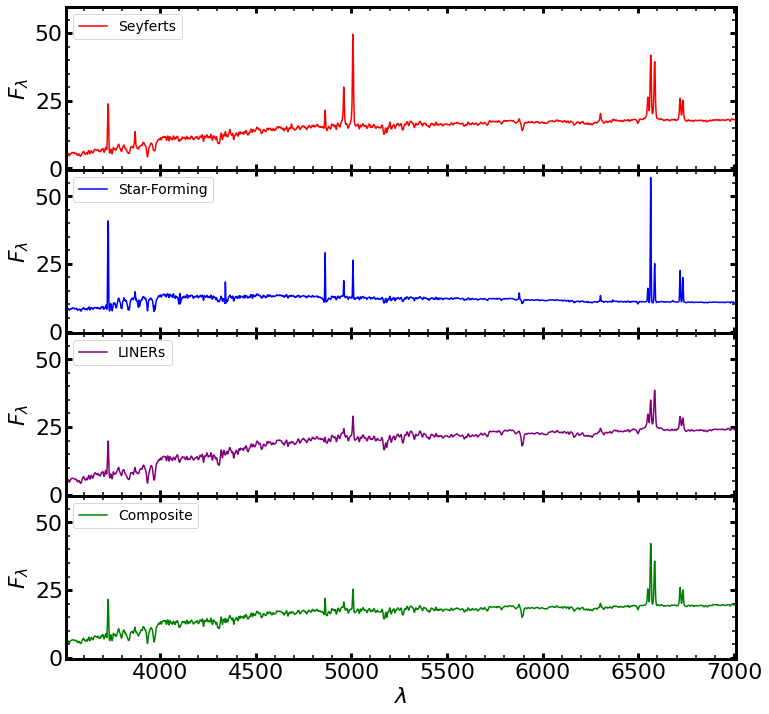

In [51]:
fig, axs = plt.subplots(4,1, figsize = (12, 12), sharex = True, sharey = True)
plt.subplots_adjust(wspace = 0., hspace = 0.)

axs[0].plot(lam_sy, flux_sy, color = 'r', label = 'Seyferts')
axs[0].legend(fontsize = 14, loc = 'upper left')
axs[0].set_ylabel('$F_{\lambda}$')

axs[1].plot(lam_sf, flux_sf, color = 'b', label = 'Star-Forming')
axs[1].legend(fontsize = 14, loc = 'upper left')
axs[1].set_ylabel('$F_{\lambda}$')

axs[2].plot(lam_liner, flux_liner, color = 'purple', label = 'LINERs')
axs[2].legend(fontsize = 14, loc = 'upper left')
axs[2].set_ylabel('$F_{\lambda}$')

axs[3].plot(lam_comp, flux_comp, color = 'g', label = 'Composite')
axs[3].legend(fontsize = 14, loc = 'upper left')
axs[3].set_xlim([3510, 7010])
axs[3].set_xlabel('$\lambda$')
axs[3].set_ylabel('$F_{\lambda}$')

Here are some galaxy properties that we can infer from the above stacked spectra - 
* The 4000$\mathring A$ break is less significant in SF galaxies compared to the other three classes. This is expected because the 4000$\mathring A$  is enhanced in old stellar populations, and the SF galaxies definitely have younger stars.
* The relative importance of Ca II H($\lambda$3969) and K($\lambda$3934) lines help in identifying the relative importance of young and old populations. This can again be seen in the SF galaxies, when H is slightly stronger than K line. In Seyferts, LINERs and composites, the old population dominates as K line is larger than H line.
* The ratio between the [NII]$\lambda$6583 and H$\alpha$ provides an estimate of gas metallicity in galaxies. On average, we see that Seyferts and LINERs have higher gas metallicity than SF and composite galaxies. In general, [NII]/H$\alpha$ varies as a function of both metallicity as well as the level of ionization.
* [OIII]$\lambda$4363 can be observed only in the stacked spectrum of SF galaxies. This can be an indicator of low metallicity. 
* The NaI D absorption line ($\lambda$5891) depends on the amount of the interstellar reddening in the galaxies. We can see that this is signicant in LINERs compared to the other three classes, which signifies that LINERs have substantial dust extinction. Dust extinction can also be seen Seyferts and composites, but it is weaker than LINERs.
* The LINERs have the reddest stellar continuum, consistent with them residing in more massive (quiescent) galaxies.

From these different observations, we can conclude that SF galaxies have a young and lower metallicity stellar population, compared to Seyfers, LINERs and Composites. Let us now look at the emission lines used to construct the BPT diagram. These lines provide information about the ionization mechanisms in the galaxies.

## Zooming on BPT lines

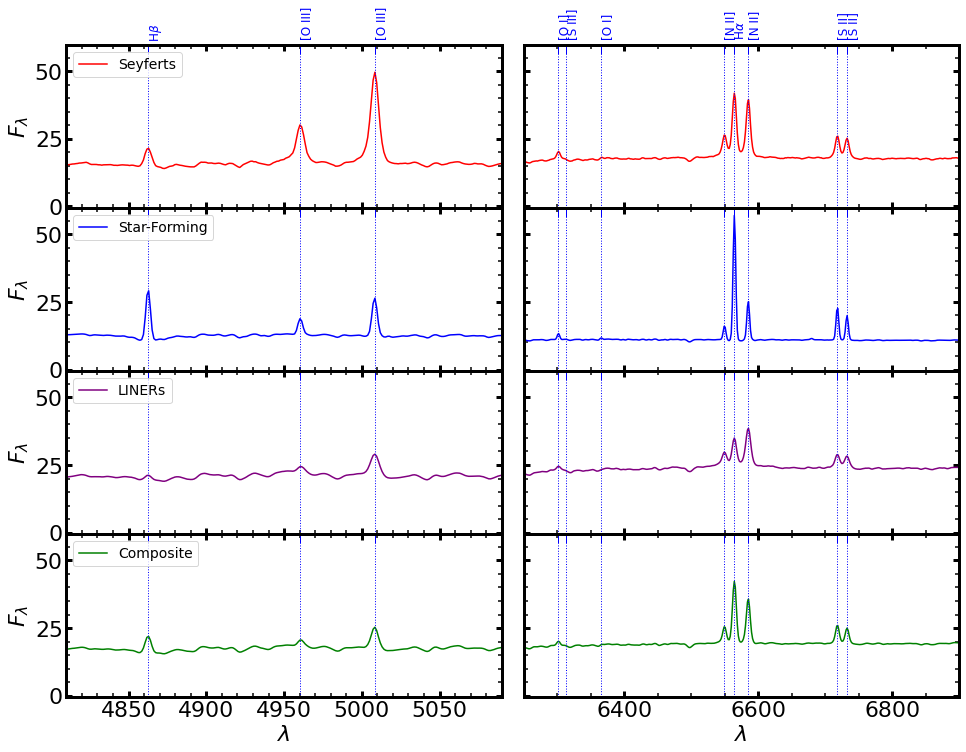

In [52]:
fig, axs = plt.subplots(4,2, figsize = (16,12), sharey = True, sharex = 'col')
plt.subplots_adjust(wspace = 0.05, hspace = 0.0)

axs[0][0].plot(lam_sy, flux_sy, color = 'r', label = 'Seyferts')
axs[0][0].legend(fontsize = 14, loc = 'upper left')
axs[0][0].set_ylabel('$F_{\lambda}$')
axs[0][0].set_xlim([4810, 5090])
add_lines(ax = axs[0][0], z=0, abs_lines = [])

axs[1][0].plot(lam_sf, flux_sf, color = 'b', label = 'Star-Forming')
axs[1][0].legend(fontsize = 14, loc = 'upper left')
axs[1][0].set_ylabel('$F_{\lambda}$')
add_lines(ax = axs[1][0], z=0, rest_frame = True, abs_lines = [], em_label = False)

axs[2][0].plot(lam_liner, flux_liner, color = 'purple', label = 'LINERs')
axs[2][0].legend(fontsize = 14, loc = 'upper left')
axs[2][0].set_ylabel('$F_{\lambda}$')
axs[2][0].set_xlabel('$\lambda$')
add_lines(ax = axs[2][0], z=0, rest_frame = True, abs_lines = [], em_label = False)
                
axs[3][0].plot(lam_comp, flux_comp, color = 'g', label = 'Composite')
axs[3][0].legend(fontsize = 14, loc = 'upper left')
axs[3][0].set_ylabel('$F_{\lambda}$')
axs[3][0].set_xlabel('$\lambda$')
add_lines(ax = axs[3][0], z=0, rest_frame = True, abs_lines = [], em_label = False)

axs[0][1].plot(lam_sy, flux_sy, color = 'r', label = 'Seyferts')
axs[0][1].set_xlim([6250, 6900])
add_lines(ax = axs[0][1], z=0, rest_frame = True, abs_lines = [])

axs[1][1].plot(lam_sf, flux_sf, color = 'b', label = 'Star-Forming')
add_lines(ax = axs[1][1], z=0, rest_frame = True, abs_lines = [], em_label = False)

axs[2][1].plot(lam_liner, flux_liner, color = 'purple', label = 'LINERs')
add_lines(ax = axs[2][1], z=0, rest_frame = True, abs_lines = [], em_label = False)

axs[3][1].plot(lam_comp, flux_comp, color = 'g', label = 'Composite')
axs[3][1].set_xlabel('$\lambda$')
add_lines(ax = axs[3][1], z=0, rest_frame = True, abs_lines = [], em_label = False)

From the above figure, we can infer the following - 
   * The [OIII]$\lambda$5007 is the strongest in Seyferts - the luminosity of this line is a tracer of AGN activity.
   * The H$\alpha$ line is a tracer for star formation. We can clearly see that it is the strongest for SF galaxies.
   * The relative fluxes of [NII]$\lambda$6853 and H$\alpha$ lines are an indicator of ionizing conditions of the nebula. When the nebula is ionized by a star burst, [NII] << H$\alpha$, while a harder ionizing radiation like an AGN increases the [NII] flux such that [NII] > H$\alpha$. This can be seen in Seyferts and LINERs. The ratio of [NII]$\lambda$6583 and H$\alpha$ is also a tracer of the gas phase metallicity in the galaxy. It is hard to separate the effects of the two from the information we have available at the moment.
   * Higher ionization radiation field and a higher ionization parameters lead to a higher [OIII]$\lambda$5007/H$\beta$.
   * LINERs have weak emission lines, compared to other classes. In addition to the possibility of being produced by low-ionization AGN, LINER-like emission can be produced in cooling flows, winds and shocks.

Stacking the spectra is thus a very valuable tool for understanding the properties of galaxies.

#### <a class="anchor" id="resources"></a>
# Resources

- SPARCL: https://astrosparcl.datalab.noirlab.edu/sparc/

- AGN Diagnostic Diagram website including a section on [optical BPT emission-line diagnostic](https://sites.google.com/site/agndiagnostics/home/bpt)

- Information about the galaxy properties from the Portsmouth Group: https://www.sdss.org/dr16/spectro/galaxy_portsmouth/

- Portsmouth stellar kinematics and emission line fluxes https://www.sdss.org/dr16/spectro/galaxy_portsmouth/#kinematics

- SDSS Spectra Basics: https://www.sdss.org/dr16/spectro/spectro_basics/#IdentifyingSDSSspectra

- SDSS Spectroscopic Data Reduction and access formats: https://www.sdss.org/dr16/spectro/pipeline/#SpectroscopicDataReduction

- Schema details about the emissionlinesport catalog can be found both on the [Data Lab Table Browser](https://datalab.noirlab.edu/query.php?name=sdss_dr12.emissionlinesport)
and on the [SDSS Skyserver webpage](http://skyserver.sdss.org/dr16/en/help/browser/browser.aspx#&&history=description+emissionLinesPort+U)

# References

[Baldwin et. al., 1981](https://ui.adsabs.harvard.edu/abs/1981PASP...93....5B/abstract)

[Kauffmann et al. 2003](https://ui.adsabs.harvard.edu/abs/2003MNRAS.346.1055K/abstract)

[Kewley et al. 2001](https://ui.adsabs.harvard.edu/abs/2001ApJ...556..121K/abstract)

[Kewley et al. 2019](https://ui.adsabs.harvard.edu/abs/2019ARA%26A..57..511K/abstract)

[Maraston & Stromback (2011)](https://ui.adsabs.harvard.edu/abs/2011MNRAS.418.2785M/abstract)

[Sarzi et al.2006](https://ui.adsabs.harvard.edu/abs/2006MNRAS.366.1151S/abstract)

[Schawinski et al. 2007](https://ui.adsabs.harvard.edu/abs/2007MNRAS.382.1415S/abstract)

[Thomas et al.2013](https://ui.adsabs.harvard.edu/abs/2013MNRAS.431.1383T/abstract)

---